In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandarallel import pandarallel

In [2]:
import fp_utils

In [3]:
fp_utils.settings.init_fp_utils()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
data_dir = Path('../data')

In [5]:
df = fp_utils.data_io.DataFrameLoader.pickle(data_dir / '1e5.pickle')
df.shape

(100000, 2575)

In [6]:
iv_cols = df.mean().parallel_apply(lambda p: p * (1 - p) / (1 - p + p * p)).sort_values(ascending=False).index

In [7]:
iv_cols

Int64Index([1510, 3197, 3403, 3026, 1212, 1487,   45,  150, 3115,   88,
            ...
            2889, 3392, 3112, 3542, 3070, 3016, 3166, 3385, 2871, 3654],
           dtype='int64', length=2575)

# Init finders

In [8]:
from fp_utils.finders import ColumnsHashFinder, SplitterTreeFinder

In [19]:
class IvColshHash5(ColumnsHashFinder):
    columns = list(iv_cols[:5])

class IvColshHash10(ColumnsHashFinder):
    columns = list(iv_cols[:10])
    
class IvColshHash15(ColumnsHashFinder):
    columns = list(iv_cols[:15])

class IvColshHash20(ColumnsHashFinder):
    columns = list(iv_cols[:20])


In [20]:
table5 = IvColshHash5(df, data_dir / 'table5')

20.170s -- IvColshHash5 init time


In [21]:
table10 = IvColshHash10(df, data_dir / 'table10')

15.377s -- IvColshHash10 init time


In [22]:
table15 = IvColshHash15(df, data_dir / 'table15')

15.877s -- IvColshHash15 init time


In [23]:
table20 = IvColshHash20(df, data_dir / 'table20')

22.781s -- IvColshHash20 init time


In [57]:
class SplitterTree100(SplitterTreeFinder):
    BUCKET_SIZE = 100

In [72]:
tree = SplitterTree100(df, data_dir / 'splitter_tree')

30.238s -- SplitterTreeFinder init time


# Check correctness

In [61]:
from fp_utils.tests import FinderCorrectnessTester, FinderSpeedTester

In [62]:
checker = FinderCorrectnessTester(tree, [table5, table10, table15, table20])

In [64]:
checker.test_random(df, 5, verbose=True)

-----
Test #000
OK -- IvColshHash5
OK -- IvColshHash10
OK -- IvColshHash15
OK -- IvColshHash20
-----
Test #001
OK -- IvColshHash5
OK -- IvColshHash10
OK -- IvColshHash15
OK -- IvColshHash20
-----
Test #002
OK -- IvColshHash5
OK -- IvColshHash10
OK -- IvColshHash15
OK -- IvColshHash20
-----
Test #003
OK -- IvColshHash5
OK -- IvColshHash10
OK -- IvColshHash15
OK -- IvColshHash20
-----
Test #004
OK -- IvColshHash5
OK -- IvColshHash10
OK -- IvColshHash15
OK -- IvColshHash20
-----


array([ True,  True,  True,  True])

# Basic tests

In [75]:
speed_tester = FinderSpeedTester([tree, table5, table10, table15, table20])

In [76]:
queries = df.sample(20)

In [77]:
stat = speed_tester.test_all(queries, verbose=True)

-----
Test #000
0.112s -- SplitterTree100
0.664s -- IvColshHash5
0.606s -- IvColshHash10
0.296s -- IvColshHash15
0.617s -- IvColshHash20
-----
Test #001
0.049s -- SplitterTree100
0.513s -- IvColshHash5
0.413s -- IvColshHash10
0.422s -- IvColshHash15
0.190s -- IvColshHash20
-----
Test #002
0.085s -- SplitterTree100
0.200s -- IvColshHash5
0.112s -- IvColshHash10
0.049s -- IvColshHash15
0.047s -- IvColshHash20
-----
Test #003
0.142s -- SplitterTree100
0.410s -- IvColshHash5
0.187s -- IvColshHash10
0.086s -- IvColshHash15
0.111s -- IvColshHash20
-----
Test #004
0.308s -- SplitterTree100
0.341s -- IvColshHash5
0.286s -- IvColshHash10
0.112s -- IvColshHash15
0.188s -- IvColshHash20
-----
Test #005
0.047s -- SplitterTree100
0.249s -- IvColshHash5
0.099s -- IvColshHash10
0.028s -- IvColshHash15
0.007s -- IvColshHash20
-----
Test #006
0.360s -- SplitterTree100
0.301s -- IvColshHash5
0.203s -- IvColshHash10
0.166s -- IvColshHash15
0.130s -- IvColshHash20
-----
Test #007
0.069s -- SplitterTree100

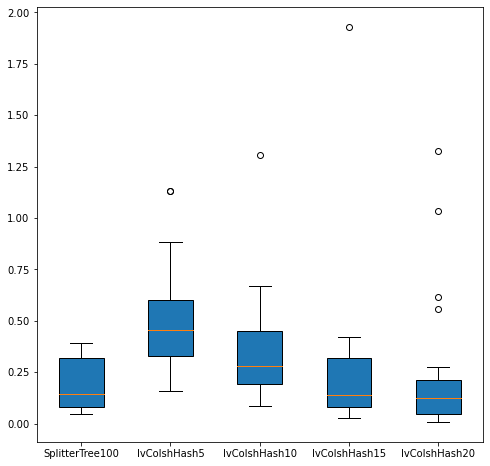

In [79]:
stat.as_boxplot()

# Bad test
`S1C([H])([H])C(C([H])([H])[H])=C([H])C([H])([H])C1([H])[H]` 

1. все нули в первых 20 iv cols
2. всего 3 ответа в базе


* `1.907s -- SplitterTree (bucket_size = 100)`
* `2.634s -- IvColshHash5`
* `3.197s -- IvColshHash10`
* `7.463s -- IvColshHash15`
* `17.660s -- IvColshHash20`

__TODO: потестить молекулы, которые попали в самый левый бакет в дереве. На них тоже по 17 секунд? Что это за молекулды?__

In [73]:
from fp_utils.draw import MoleculeDrawer

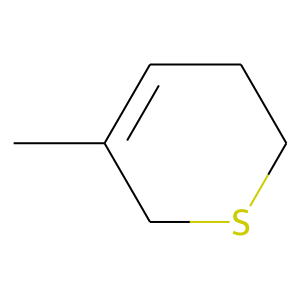

In [74]:
MoleculeDrawer.draw_one('S1C([H])([H])C(C([H])([H])[H])=C([H])C([H])([H])C1([H])[H]')

In [84]:
fp = df.loc['S1C([H])([H])C(C([H])([H])[H])=C([H])C([H])([H])C1([H])[H]']

In [87]:
from fp_utils import CatchTime

In [89]:
catch_time = CatchTime()
with catch_time:
    ans = list(table20.find(fp, ans_count=10))

In [91]:
catch_time

CatchTime(CatchTime, 17.258 sec)

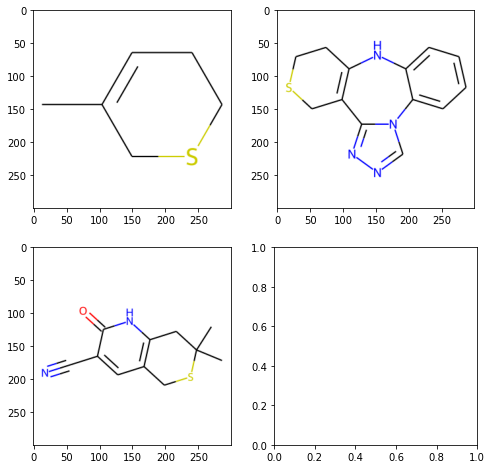

In [98]:
MoleculeDrawer.draw_many(ans, shape=(2, 2), figsize=(8, 8))

# Compare Splitter tree and 15 Ivan's columns

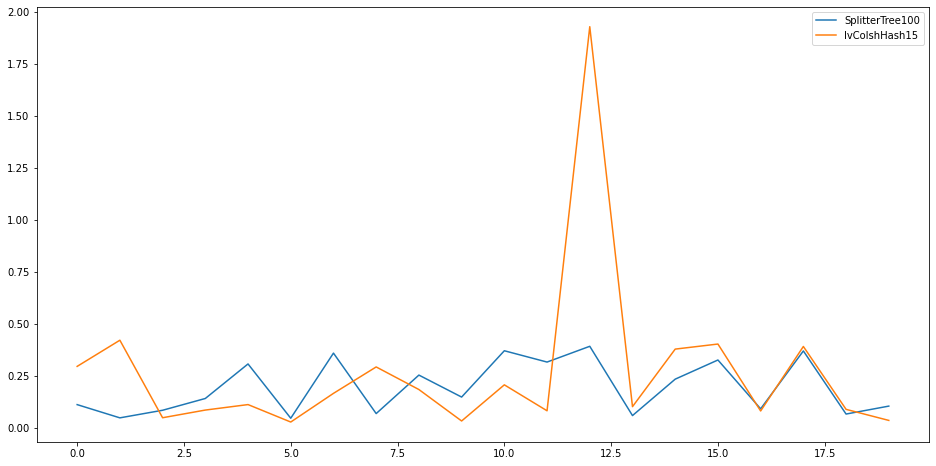

In [81]:
stat.take([SplitterTree100, IvColshHash15]).as_plot()

# Test: find only first 10

In [103]:
stat3 = speed_tester.test_all(queries, ans_count=10, verbose=True)

-----
Test #000
0.172s -- SplitterTree100
0.658s -- IvColshHash5
0.595s -- IvColshHash10
0.244s -- IvColshHash15
0.335s -- IvColshHash20
-----
Test #001
0.083s -- SplitterTree100
0.444s -- IvColshHash5
0.439s -- IvColshHash10
0.312s -- IvColshHash15
0.123s -- IvColshHash20
-----
Test #002
0.116s -- SplitterTree100
0.216s -- IvColshHash5
0.104s -- IvColshHash10
0.039s -- IvColshHash15
0.033s -- IvColshHash20
-----
Test #003
0.264s -- SplitterTree100
0.391s -- IvColshHash5
0.137s -- IvColshHash10
0.079s -- IvColshHash15
0.059s -- IvColshHash20
-----
Test #004
0.432s -- SplitterTree100
0.320s -- IvColshHash5
0.310s -- IvColshHash10
0.091s -- IvColshHash15
0.076s -- IvColshHash20
-----
Test #005
0.048s -- SplitterTree100
0.341s -- IvColshHash5
0.124s -- IvColshHash10
0.031s -- IvColshHash15
0.009s -- IvColshHash20
-----
Test #006
0.402s -- SplitterTree100
0.321s -- IvColshHash5
0.230s -- IvColshHash10
0.189s -- IvColshHash15
0.149s -- IvColshHash20
-----
Test #007
0.040s -- SplitterTree100

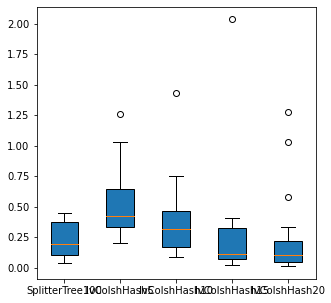

In [107]:
stat3.as_boxplot(figsize=(5, 5))

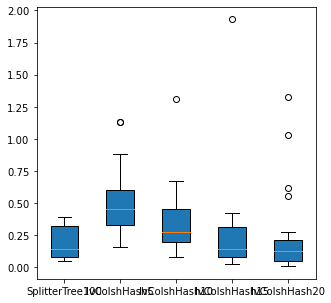

In [108]:
stat.as_boxplot(figsize=(5, 5))

__Объяснения:__
* Бага в коде? (Посмотрел, не нашёл)
* В среднем в базе менее 10 ответв, поэтому на статистику не влияет

# Test subcolumns

In [42]:
from fp_utils.finders import SubColsFinder

In [164]:
class SplitterTree1600(SplitterTreeFinder):
    BUCKET_SIZE = 1600

__На SplitterTree1500 не построилось => гипотеза: splitter tree делит не только по первым iv columns__

In [161]:
class SubCol100_Tree(SubColsFinder):
    columns = iv_cols[:100]

In [165]:
sc100_tree1600 = SubCol100_Tree(df, SplitterTree1600, data_dir / 'st100')

1.566s -- SplitterTreeFinder init time
3.155s -- SubCol100_Tree init time


In [169]:
class SubCol100_Table(SubColsFinder):
    columns = iv_cols[:100]

In [170]:
sc100_table15 = SubCol100_Table(df, IvColshHash15, data_dir / 'table100')

7.599s -- IvColshHash15 init time
9.145s -- SubCol100_Table init time


In [171]:
speed_tester3 = FinderSpeedTester([sc100_tree1600, sc100_table15])

In [173]:
stat4 = speed_tester3.test_all(queries, verbose=True, ans_count=10)

-----
Test #000
0.028s -- SubCol100_Tree
0.023s -- SubCol100_Table
-----
Test #001
0.023s -- SubCol100_Tree
0.062s -- SubCol100_Table
-----
Test #002
0.007s -- SubCol100_Tree
0.008s -- SubCol100_Table
-----
Test #003
0.017s -- SubCol100_Tree
0.013s -- SubCol100_Table
-----
Test #004
0.019s -- SubCol100_Tree
0.022s -- SubCol100_Table
-----
Test #005
0.007s -- SubCol100_Tree
0.003s -- SubCol100_Table
-----
Test #006
0.022s -- SubCol100_Tree
0.041s -- SubCol100_Table
-----
Test #007
0.017s -- SubCol100_Tree
0.069s -- SubCol100_Table
-----
Test #008
0.018s -- SubCol100_Tree
0.020s -- SubCol100_Table
-----
Test #009
0.015s -- SubCol100_Tree
0.006s -- SubCol100_Table
-----
Test #010
0.012s -- SubCol100_Tree
0.041s -- SubCol100_Table
-----
Test #011
0.026s -- SubCol100_Tree
0.012s -- SubCol100_Table
-----
Test #012
0.026s -- SubCol100_Tree
0.420s -- SubCol100_Table
-----
Test #013
0.005s -- SubCol100_Tree
0.013s -- SubCol100_Table
-----
Test #014
0.027s -- SubCol100_Tree
0.082s -- SubCol100_T

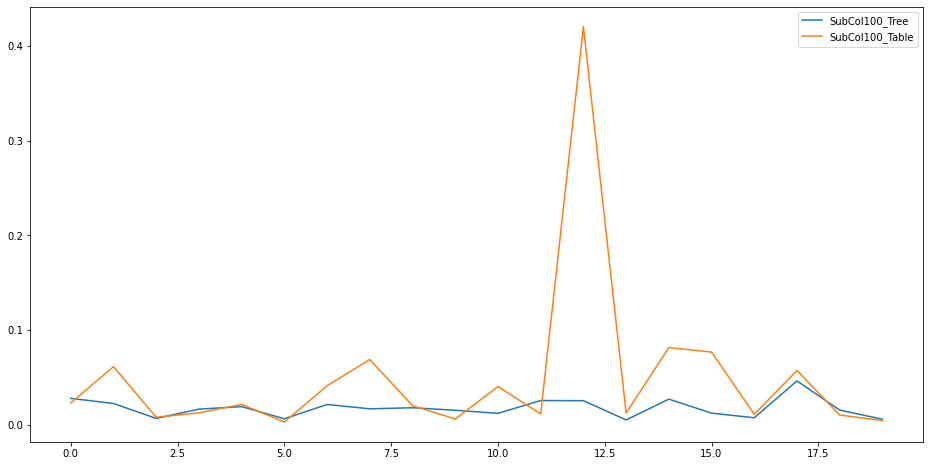

In [174]:
stat4.as_plot()

In [178]:
queries1000 = df.sample(1000)

In [179]:
%%time
stat5 = speed_tester3.test_all(queries1000, verbose=False, ans_count=10)

CPU times: user 3min 9s, sys: 10.4 s, total: 3min 19s
Wall time: 3min 19s


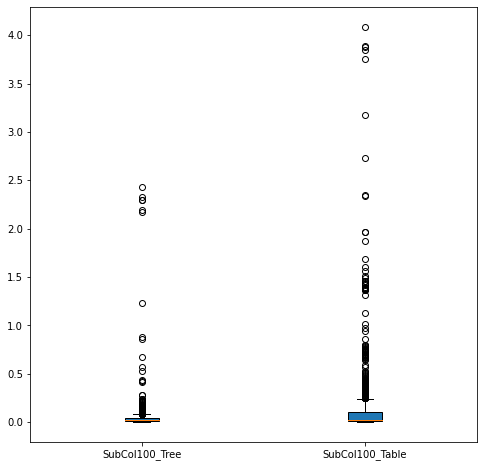

In [186]:
stat5.as_boxplot()

In [181]:
stat5

SubCol100_Tree:
	0.002 -- min
	2.426 -- max
	0.050 -- mean
	0.021 -- median
SubCol100_Table:
	0.001 -- min
	4.086 -- max
	0.150 -- mean
	0.023 -- median